<a href="https://colab.research.google.com/github/CuciureanuDan/Lane-Detection-Project/blob/main/LaneDetectionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Detection of lane markers



---


*   **Objective:** Develop an application in Python  to detect lane markers in images using numerical processing techniques, specifically leveraging the Hough Transform algorithm.

*   **Brief description:**
In driver assistance systems, lane detection plays a crucial role in enhancing road safety. Accurate lane detection can alert drivers if they unintentionally drift out of their lane or provide information about upcoming turns, whether they are mild or sharp. This project utilizes the Hough Transform algorithm to detect lane markers in images. The Hough Transform identifies lines by accumulating votes in a parameter space, followed by detecting peaks that indicate potential lines in the image, ensuring reliable and efficient lane detection.



In this project we will work with some libraries frequently used in image processing. For example, to display  images  or some graphics,we will use *matplotlib*. For reading and displaying images in common formats(e.g., JPEG,PNG) we will use *matplotlib.image*. We will also use *numpy* for numerical operations on matrices.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
from google.colab.patches import cv2_imshow
import numpy as np
import cv2

If the code runs successfully, no message will be displayed.

Firstly, we need to select the image we want to open. We'll use the *upload* function from the files module of the already imported google.colab package. After selecting the file, its name will be stored in the variable uploaded, and then assigned to imgFileName, as shown in the following cell:

In [ ]:
uploaded = files.upload()
imgFileName=list(uploaded.keys())[0]

Saving laneB2.jpg to laneB2.jpg


Later we will read the image we chose using the *imread* function. When calling this function, we will specify the library it belongs to(in our case cv2).

In [ ]:
ImgIn = cv2.imread(imgFileName)
if ImgIn is None:
  print("The image cannot be opened, or no image with the specified name was found.")

In this part of the code, we will display the type and dimensions of the image, then we will convert the image to grayscale using *cv2.cvtColor* and display both versions of the image. For analyzing the distribution of pixel intensities in the image we called the *hist* function.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


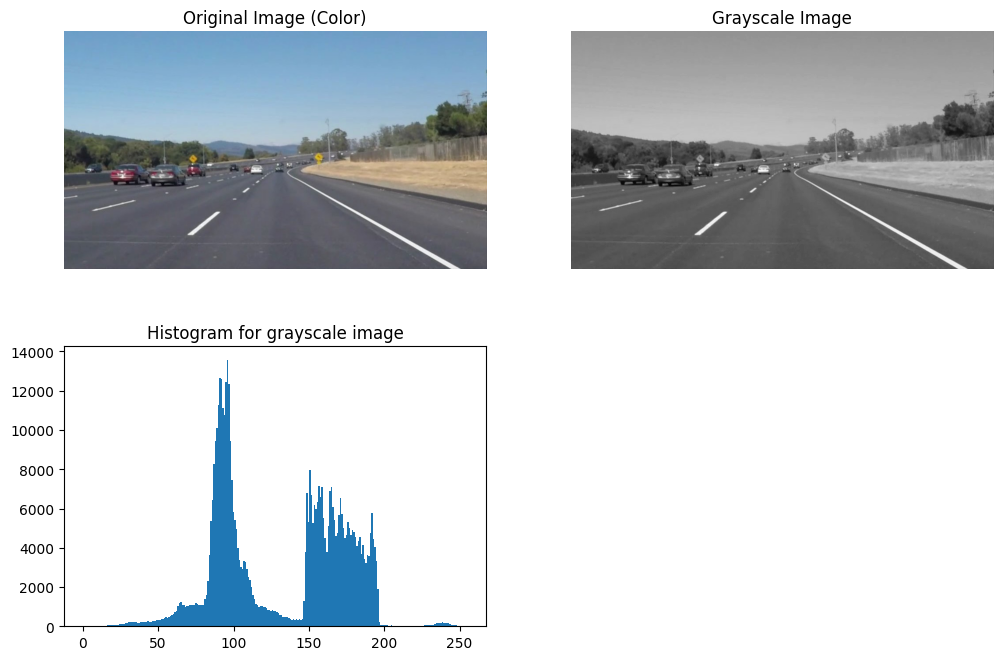

In [ ]:
print('This image is:', type(ImgIn), 'with dimesions:', ImgIn.shape)
ImgIn_gray = cv2.cvtColor(ImgIn, cv2.COLOR_BGR2GRAY) # Conversion to gray

fig, axes = plt.subplots(2, 2, figsize = (12,8))
axes[0,0].imshow(cv2.cvtColor(ImgIn, cv2.COLOR_BGR2RGB))
axes[0,0].axis('off')
axes[0,0].set_title("Original Image (Color)")
axes[0,1].imshow(ImgIn_gray, cmap='gray')
axes[0,1].set_title("Grayscale Image")
axes[0,1].axis('off')
axes[1,0].hist(ImgIn_gray.ravel(),256,[0,255])
axes[1,0].set_title("Histogram for grayscale image")
axes[1,1].axis('off')

plt.show()

Identifying as many edges as possible in an image is the key to an efficient algorithm. So, it is important to eliminate any noise that may cause false edges, which can negatively impact edge detection. To reduce noise we will apply a filter known as Gaussian Blur.

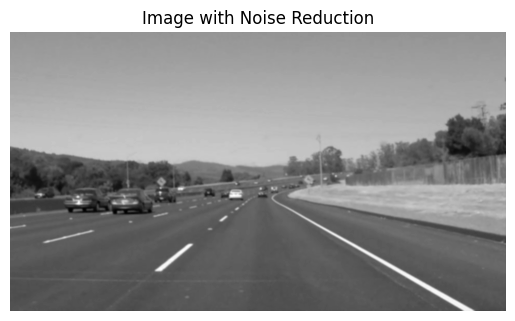

In [ ]:
ImgIn_gray_blur = cv2.GaussianBlur(ImgIn_gray, (5, 5), 0)

plt.figure()
plt.imshow(ImgIn_gray_blur, cmap='gray')
plt.title('Image with Noise Reduction')
plt.axis('off')
plt.show()


Now we apply the Canny edge detection algorithm on `ImgIn_gray_blur`. The method uses two thresholds: `t_lower` and `t_upper` , which determine the sensitivity for detecting edges. It calculates gradients using a Sobel operator with an `aperture_size` of 3 (by default). Areas with strong intensity changes (gradients) are marked as edges, producing a binary image `ImgIn_canny`, where edges appear as white lines on a black background. The result is showing prominent contours and boundaries.

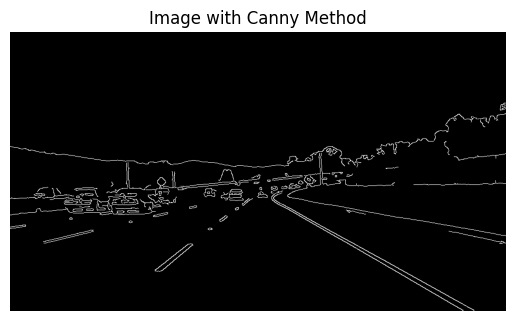

In [ ]:
t_lower = 50  # Lower Threshold
t_upper = 150  # Upper threshold
aperture_size = 3  # Aperture size

ImgIn_canny = cv2.Canny(ImgIn_gray_blur, t_lower, t_upper, apertureSize=aperture_size)

plt.figure()
plt.imshow(ImgIn_canny, cmap='gray')
plt.title('Image with Canny Method')
plt.axis('off')
plt.show()

Displaying the Canny edge-detected image with coordinate axes helps identify the pixel coordinates needed for selecting a Region of Interest (ROI). This visualization aids in precisely defining the area of the image containing lane markers, reducing noise and irrelevant features. Using the axes, we can easily determine the coordinates for creating a polygonal mask, focusing the analysis on the lane area and improving edge detection accuracy.

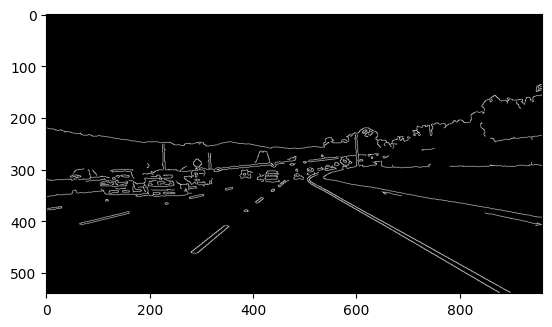

In [ ]:
plt.imshow(ImgIn_canny, cmap='gray')
plt.show()


In this step, we create a binary mask using a polygon defined by specific vertices. The mask helps isolate the Region of Interest (ROI) where lane markers are expected. The polygon is constructed using four points: the bottom-left, bottom-right, top-right, and top-left corners, forming a trapezoidal shape. This shape is chosen based on the typical perspective view of road lanes.

The mask is generated using the `cv2.fillPoly` function, which fills the specified polygon with white (255) on a black (0) background of the same size as the Canny edge-detected image (`ImgIn_canny`). The resulting mask highlights the area of interest while filtering out irrelevant parts of the image. When visualized, this mask shows only a trapezoid on a black/magenta background, indicating the region where further lane detection analysis will be focused.

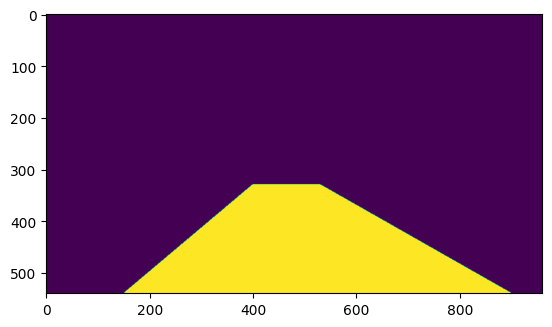

In [ ]:
height = ImgIn_canny.shape[0]
polygons = np.array([ [(150, height), (900, height),(530, 330), (400, 330)] ]) # left side, right side, right middle, left middle
#polygons = np.array([ [(200, height), (1150, height), (650, 350)]]) # left right [midlle and height]
mask = np.zeros_like(ImgIn_canny)
cv2.fillPoly(mask, polygons, 255)

plt.imshow(mask)
plt.show()


In this step, we apply the mask to the Canny edge-detected image using a bitwise AND operation with `cv2.bitwise_and`. The `masked_image` is the result of combining `ImgIn_canny` and the mask, keeping only the pixels within the polygonal Region of Interest (ROI).

This operation filters out everything outside the trapezoidal mask, leaving only the edges within the ROI visible. It effectively isolates the lane lines from the rest of the image, reducing noise and irrelevant features. Visualizing the `masked_image` shows the detected edges confined to the ROI, making the subsequent lane detection process more efficient and accurate.

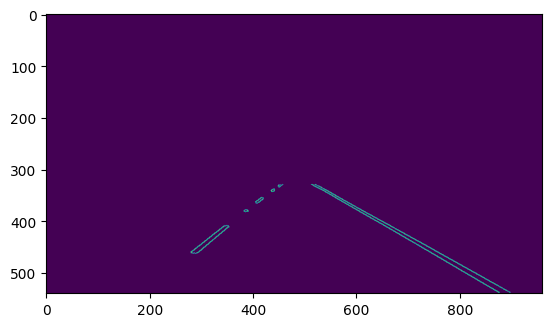

In [ ]:
masked_image = cv2.bitwise_and(ImgIn_canny, mask)

plt.imshow(masked_image)
plt.show()

masked_copy = np.copy(masked_image)

This line of code detects lines in an image using the Probabilistic Hough Line Transform, that is a more efficient implementation of the Hough Line Transform. It gives as output the extremes of the detected lines (x<sub>0</sub>,y<sub>0</sub>,x<sub>1</sub>,y<sub>1</sub>). Each parameter can be modified based on the input image:

`cv.HoughLinesP(	image, rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]]	)`

- `image` is the input image, usually a binary image (e.g., result of edge detectection, `masked_image` in our case).

- `rho` represents the distance resolution in pixels of Hough accumulator. Lower values (e.g., *1*) increase the precision of line detection but may introduce noise, Higher values(e.g., *3 or more*) reduce sensitivity and detect fewer, more prominent lines.

- `theta` represents the angular resolution in radians (default is *np.pi/180*, equivalent to 1 degree). Decreasing this value (e.g., *np.pi/360*) increases angular precision, while increasing it (e.g., *np.pi/90*) reduces precision but speeds up processing.

- `threshold` parameter (default is *150*) defines the minimum number of votes needed to detect a line. Lowering this value (e.g., *100*) makes the detection more sensitive, while increasing it (e.g., *200*) makes it more conservative, detecting fewer lines.

- `lines` is typically an empty array (`np.array([])`) where the detected lines will be stored.
- `minLineLength` (default is *50*) specifies the minimum length of a line in pixels. Increasing this value (e.g., *70*) filters out shorter, potentially noisy lines, while decreasing it (e.g., *30*) allows shorter lines to be detected.
- `maxLineGap` (default is *5*) is the maximum distance between line segments to be considered part of the same line. Higher values (e.g., *10*) merge nearby segments into longer lines, while lower values (e.g., *2*) keep segments separate even if they are close.

In [ ]:
lines = cv2.HoughLinesP(masked_image, 1, np.pi/180, 40, np.array([]), minLineLength=40, maxLineGap=20)

This code creates a blank image (`line_img`) of the same size as `masked_image`, with 3 color channels (uint8 type). It defines the line color as red ([255, 0, 0]) and thickness as 2. The for loop iterates over each detected line, extracting the coordinates (x1, y1, x2, y2) and drawing the line on `line_img` using `cv2.line()`.

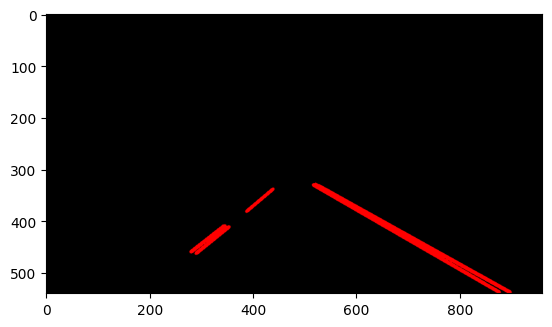

In [ ]:
line_img = np.zeros((masked_image.shape[0], masked_image.shape[1], 3), dtype=np.uint8) # check dtype ?

color = [255, 0, 0] # red color
thickness = 5 # line thickness

for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

plt.imshow(line_img)

---
This is the final version of the original image with the detected traffic lanes overlaid, providing a clear visualization of the results.





(-0.5, 959.5, 539.5, -0.5)

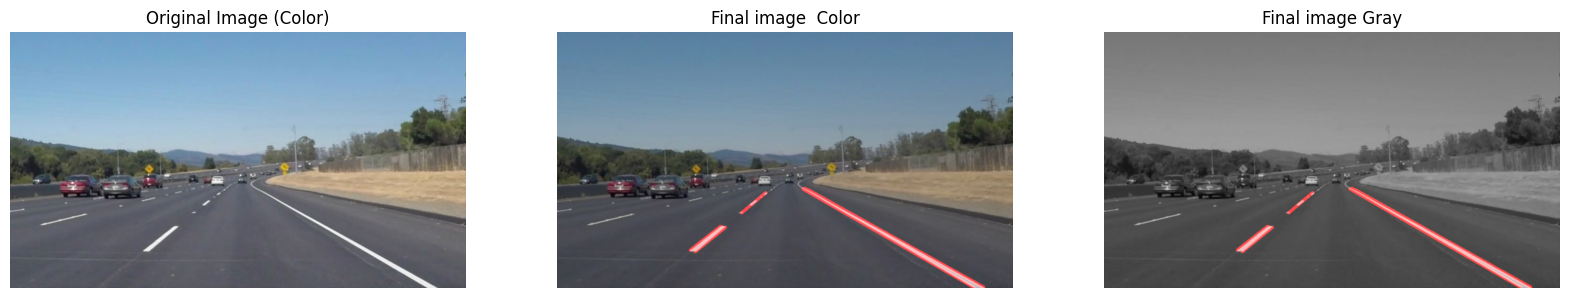

In [ ]:
# Convert the single-channel grayscale image to a 3-channel grayscale image
gray_img_3ch = cv2.cvtColor(ImgIn_gray, cv2.COLOR_GRAY2BGR)

img_with_lines_color = cv2.addWeighted(cv2.cvtColor(ImgIn, cv2.COLOR_BGR2RGB), 0.8, line_img, 1, 0)
img_with_lines_gray = cv2.addWeighted(gray_img_3ch, 0.8, line_img, 1, 0)


fig, axes = plt.subplots(1, 3, figsize = (20,10))
axes[0].imshow(cv2.cvtColor(ImgIn, cv2.COLOR_BGR2RGB))
axes[0].axis('off')
axes[0].set_title("Original Image (Color)")
axes[1].imshow(img_with_lines_color, cmap='gray')
axes[1].set_title("Final image  Color")
axes[1].axis('off')
axes[2].imshow(img_with_lines_gray, cmap='gray')
axes[2].set_title("Final image Gray")
axes[2].axis('off')

To download the processed image, you can save it to a file using `cv2.imwrite()` and then use `files.download()` to trigger the download. This will create a download link for the image, allowing you to save it to your local computer.

In [ ]:
# Save the image
cv2.imwrite('/content/final_image5.png', cv2.cvtColor(img_with_lines_color, cv2.COLOR_BGR2RGB))

# Trigger the download
files.download('/content/final_image5.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

If you want to export it as .html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/Colab Notebooks/LaneDetectionProject.ipynb' --output='/content/LaneDetProj.html'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/LaneDetectionProject.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 1288872 bytes to /content/LaneDetProj.html


In [ ]:
from google.colab import files
files.download('LaneDetProj.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---


# Datas:

**- For laneA:**

[ Lower, Upper, Aperture ] : [ 150, 300, 3]

[ left side, right side, right middle, left middle ] : [ (0, height), (1300, height),(700, 330), (380, 330) ]

~~[ left right [midlle and height] ] : [ ]~~

[ rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]] ] : [1, np.pi/180, 140, np.array([]), minLineLength=30, maxLineGap=20 ]

**- For laneB:**

[ Lower, Upper, Aperture ] : [ 50, 150 , 3 ]

[ left side, right side, right middle, left middle ] : [ (150, height), (900, height),(530, 330), (400, 330) ]

~~[ left right [midlle and height] ] : [ ]~~

[ rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]] ] : [ 1, np.pi/180, 40, np.array([]), minLineLength=40, maxLineGap=20 ]

**- For laneC:**

[ Lower, Upper, Aperture ] : [ 100, 300, 3]

[ left side, right side, right middle, left middle ] : [ (100, height), (1250, height),(850, 340), (450, 340) ]

~~[ left right [midlle and height] ] : [ ]~~

[ rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]] ] : [ 1, np.pi/180, 20, np.array([]), minLineLength=20, maxLineGap=10 ]

**- For laneD:**

[ Lower, Upper, Aperture ] : [ 100, 300, 3]

[ left side, right side, right middle, left middle ] : [ (150, height - 5), (900, height - 5),(620, 310), (350, 310) ]

~~[ left right [midlle and height] ] : [ ]~~

[ rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]] ] : [ 1, np.pi/180, 20, np.array([]), minLineLength=10, maxLineGap=10 ]

